# Advanced Machine Learning Assignment 2
By Benedetta Felici, Daria Mihaila, Jasper Pieterse

In [ ]:
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from numba import jit
from numba.typed import List
from numba import int64, float64
from scipy.stats import norm
from scipy.special import expit
from scipy.optimize import approx_fprime
np.random.seed(0)

## MCMC Exercise 1: Elongated Gaussian

### 1.) Sampling using Metropolis-Hasting

In [ ]:
# true mean, precision and covariance of the Gaussian distribution
true_mean = [0.0, 0.0]
Sigma = np.array([[250.25, -249.75],
                  [-249.75, 250.25]])
true_cov = np.linalg.inv(Sigma)

@jit(nopython=True)
def energy(s,Sigma):
  return -0.5 * s.T @ Sigma @ s

@jit(nopython=True)
def metropolis_hastings(N, initial_state, proposal_std, Sigma):
    samples = np.zeros((N, *initial_state.shape)) # Preallocate array for performance
    acceptance_count = 0
    current_state = np.copy(initial_state)
    current_energy = energy(current_state, Sigma)

    for i in range(1, N):
        proposal = current_state + proposal_std * np.random.randn(*current_state.shape)
        proposal_energy = energy(proposal, Sigma)
        energy_diff = proposal_energy - current_energy
        a = min(1, np.exp(energy_diff))

        if np.random.rand() < a:
            current_state = proposal
            current_energy = proposal_energy
            acceptance_count += 1

        samples[i] = current_state

    return samples, acceptance_count / N

def create_ellipse(n_std, color, mean = [0, 0],cov = true_cov):
  vals, vecs = np.linalg.eigh(cov)
  order = vals.argsort()[::-1]
  vals, vecs = vals[order], vecs[:, order]
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
  width, height = 2 * n_std * np.sqrt(vals)
  return Ellipse(xy=mean, width=width, height=height, angle=theta, linestyle ='--', edgecolor= color, fc='None', lw=2)

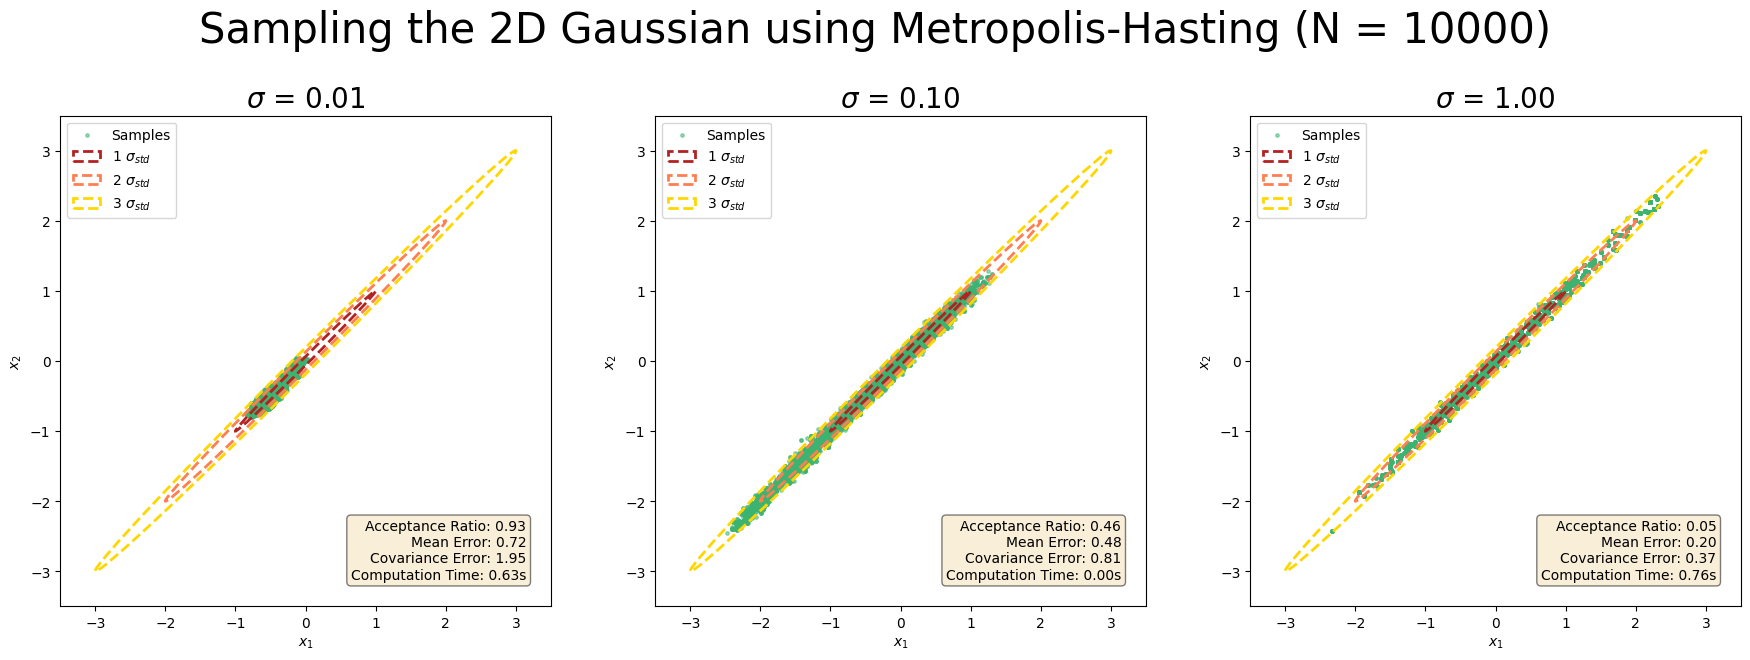

In [ ]:
#initialize
N = 10000
sigma_list = [0.01,0.1,1]
initial_state = np.array([0.0,0.0])

#setting up the plots
plt.figure(figsize=(18, 6))
plt.suptitle(f'Sampling the 2D Gaussian using Metropolis-Hasting (N = {N})', y=1.05, size=30)

for i, proposal_sigma in enumerate(sigma_list):
    start_time = time.time()
    samples_mh, a_ratio = metropolis_hastings(N=N, initial_state=initial_state, proposal_std=proposal_sigma, Sigma = Sigma)
    comp_time = time.time() - start_time

    # make a subplot
    plt.subplot(1, 3, i + 1)

    # plot the samples
    plt.scatter(samples_mh[:, 0], samples_mh[:, 1], alpha=0.5, s=6, color='MediumSeaGreen', label='Samples')

    # plot the std ellipses
    colors = ['DarkOrchid', 'FireBrick', 'Coral', 'Gold']
    for n_std in [1, 2, 3]:
        ellipse = create_ellipse(n_std, colors[n_std])
        plt.gca().add_patch(ellipse)
        ellipse.set_label(f'{n_std} $\sigma_{{std}}$')

    # compute mean error and covariance error
    mean = np.mean(samples_mh, axis=0)
    cov = np.cov(samples_mh.T)
    mean_error = np.linalg.norm(mean - true_mean)
    cov_error = np.linalg.norm(cov - true_cov)

    # setting up plot
    plt.title(f'$\sigma$ = {proposal_sigma:.2f}', size=20)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(-3.5, 3.5)
    plt.ylim(-3.5, 3.5)
    plt.gca().set_aspect('equal', 'box')
    plt.legend(loc = 'best')

    # displaying other information in a more convenient place
    info_text = f'Acceptance Ratio: {a_ratio:.2f}\nMean Error: {mean_error:.2f}\nCovariance Error: {cov_error:.2f}\nComputation Time: {comp_time:.2f}s'
    plt.text(0.95, 0.05, info_text, transform=plt.gca().transAxes, horizontalalignment='right', verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


plt.tight_layout()
plt.show()


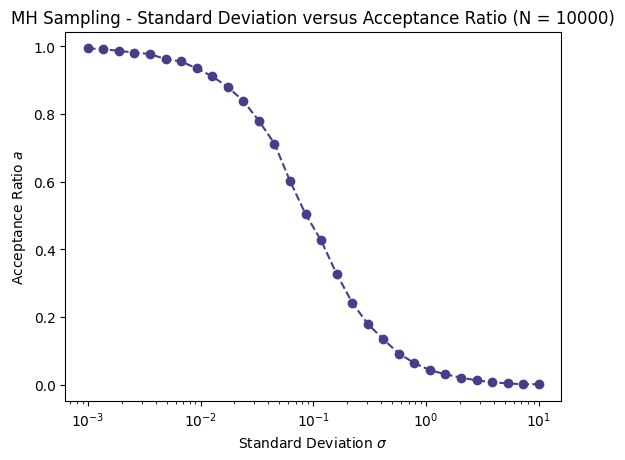

In [ ]:
# sampler parameters
N = 10000  # number of samples
sigma_list = np.logspace(np.log10(0.001),np.log10(10),30) #sigmas to sample over
initial_state = np.array([0.01, 0.01])

#initialize lists
acceptance_ratios = []

# run the sampler for multiple sigmas
for proposal_sigma in sigma_list:
  samples, a= metropolis_hastings(N,initial_state, proposal_sigma, Sigma)

  mean = np.mean(samples, axis=0)
  cov = np.cov(samples.T)

  mean_error = np.linalg.norm(mean - true_mean)
  cov_error = np.linalg.norm(cov - true_cov)

  acceptance_ratios.append(a)

# plot the samples
plt.plot(sigma_list, acceptance_ratios, color = 'DarkSlateBlue',marker='o', linestyle='dashed')
plt.title(f'MH Sampling - Standard Deviation versus Acceptance Ratio (N = {N})')
plt.xlabel('Standard Deviation $\sigma$')
plt.ylabel('Acceptance Ratio $a$')
plt.xscale('log')
plt.show()


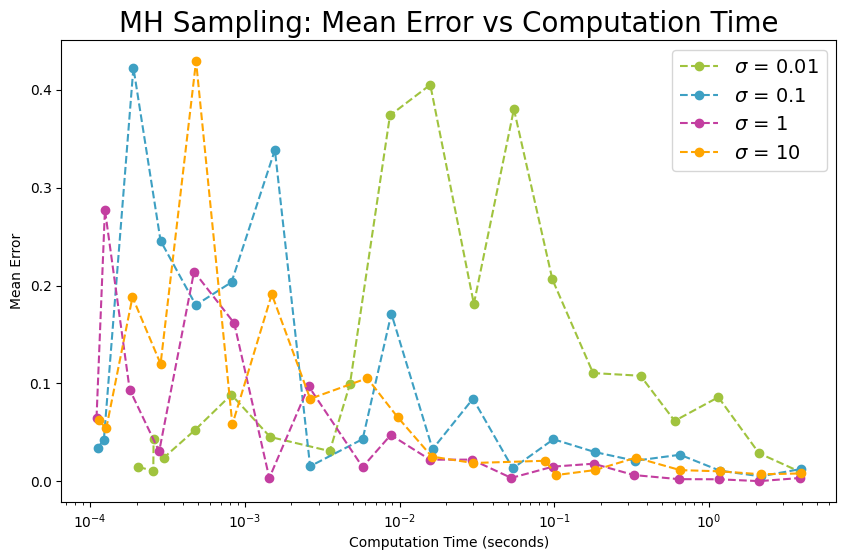

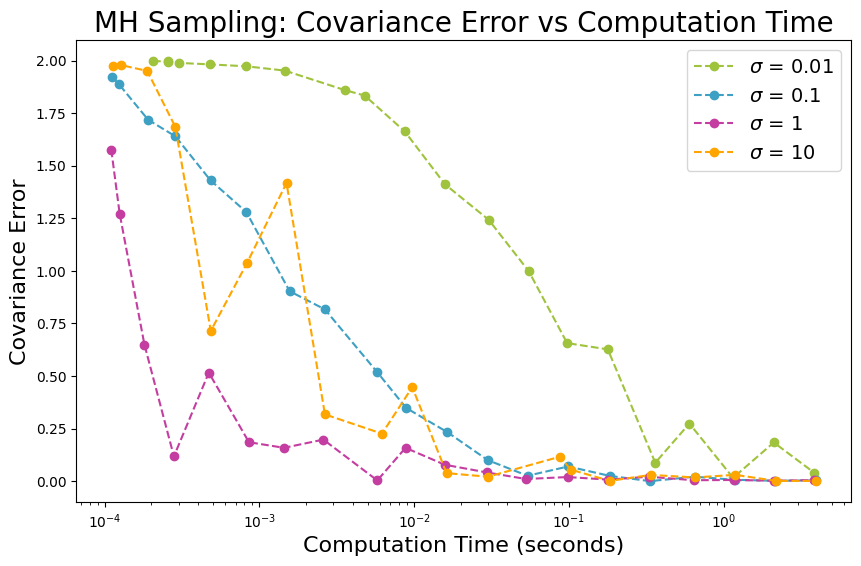

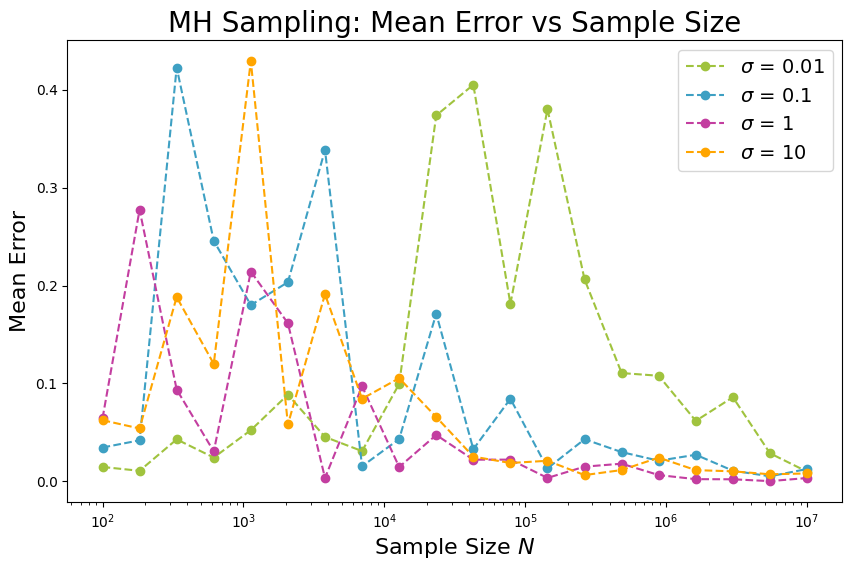

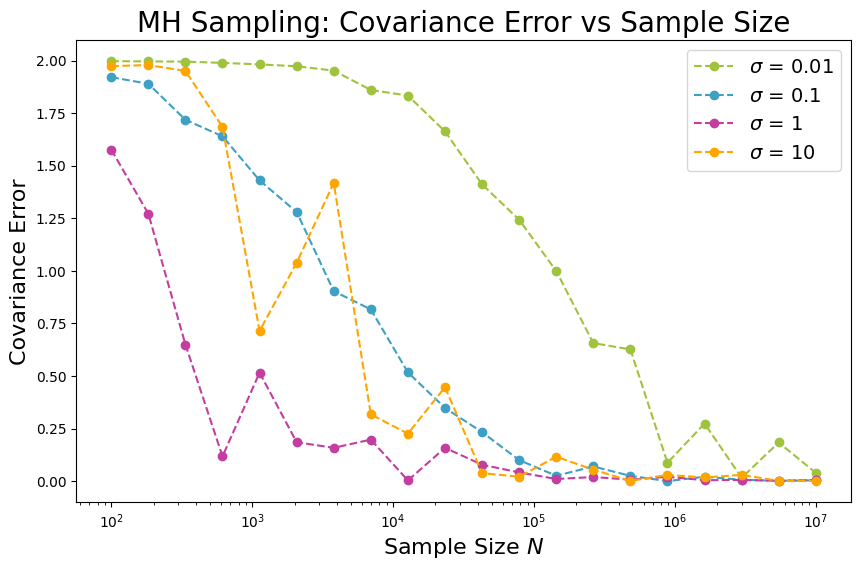

In [ ]:
# sampler parameters
num_runs = 10  # number of runs for averaging
N_list = np.logspace(np.log10(100),np.log10(10000000),20) # values of N
sigma_list = [0.01,0.1,1,10]
initial_state = np.array([0.0, 0.0])

# lists to store computation times and errors for each sigma
all_computation_times = []
all_mean_errors = []
all_cov_errors = []

for proposal_sigma in sigma_list:
    computation_times = []
    mean_errors = []
    cov_errors = []

    for N in N_list:
        N = int(N)
        run_means = []
        run_covs = []
        start_time = time.time()

        for _ in range(num_runs):
            initial_state = np.random.uniform(-0.1, 0.1, size=(2,)) #initialize at different places, comment or uncomment
            samples, _ = metropolis_hastings(N, initial_state, proposal_sigma, Sigma)

            # calculate mean and covariance for this run
            run_mean = np.mean(samples, axis=0)
            run_cov = np.cov(samples.T)

            run_means.append(run_mean)
            run_covs.append(run_cov)

        comp_time = (time.time() - start_time) / num_runs #average cpu time per run

        # Average the means and covariances across runs
        avg_run_mean = np.mean(run_means, axis=0)
        avg_run_cov = np.mean(run_covs, axis=0)

        mean_error = np.linalg.norm(avg_run_mean- true_mean)
        cov_error = np.linalg.norm(avg_run_cov - true_cov)

        computation_times.append(comp_time)
        mean_errors.append(mean_error)
        cov_errors.append(cov_error)

    all_computation_times.append(computation_times)
    all_mean_errors.append(mean_errors)
    all_cov_errors.append(cov_errors)

colors = ['#a0c33e','#3ea0c3','#c33ea0', 'orange']
# plot mean error against computation time
plt.figure(figsize=(10, 6))
for i, proposal_sigma in enumerate(sigma_list):
    plt.plot(all_computation_times[i], all_mean_errors[i], label=f'$\sigma$ = {proposal_sigma}', color = colors[i],marker='o', linestyle='dashed')
plt.title('MH Sampling: Mean Error vs Computation Time', size = 20)
plt.xlabel('Computation Time (seconds)')
plt.ylabel('Mean Error')
plt.legend(prop={'size': 14})
plt.xscale('log')
plt.show()

# plot covariance error against computation time
plt.figure(figsize=(10, 6))
for i, proposal_sigma in enumerate(sigma_list):
    plt.plot(all_computation_times[i], all_cov_errors[i], label=f'$\sigma$ = {proposal_sigma}', color = colors[i],marker='o', linestyle='dashed')
plt.title('MH Sampling: Covariance Error vs Computation Time', size = 20)
plt.xlabel('Computation Time (seconds)', size = 16)
plt.ylabel('Covariance Error', size = 16)
plt.xscale('log')
plt.legend(prop={'size': 14})
plt.show()

# plot mean error against N
plt.figure(figsize=(10, 6))
for i, proposal_sigma in enumerate(sigma_list):
    plt.plot(N_list, all_mean_errors[i], label=f'$\sigma$ = {proposal_sigma}', color = colors[i],marker='o', linestyle='dashed')
plt.title('MH Sampling: Mean Error vs Sample Size', size = 20)
plt.xlabel('Sample Size $N$', size = 16)
plt.ylabel('Mean Error', size = 16)
plt.xscale('log')
plt.legend(prop={'size': 14})
plt.show()

# plot covariance error against N
plt.figure(figsize=(10, 6))
for i, proposal_sigma in enumerate(sigma_list):
    plt.plot(N_list, all_cov_errors[i], label=f'$\sigma$ = {proposal_sigma}', color = colors[i],marker='o', linestyle='dashed')
plt.title('MH Sampling: Covariance Error vs Sample Size', size = 20)
plt.xlabel('Sample Size $N$', size = 16)
plt.ylabel('Covariance Error', size = 16)
plt.xscale('log')
plt.legend(prop={'size': 14})
plt.show()

### 2.) Sampling using Hamiltonian Monte Carlo

In [ ]:
@jit(nopython=True)
def grad_E(s, Sigma):
    return Sigma @ s

@jit(nopython=True)
def hamiltonian_monte_carlo(N, s0, L, epsilon, Sigma):
    samples = [s0]
    acceptance_count = 0

    for _ in range(N):
        s = samples[-1].copy()
        p = np.random.normal(0, 1, 2)
        current_p = np.copy(p)

        current_U = energy(samples[-1], Sigma)
        current_K = np.sum(current_p**2) / 2
        current_H = current_U + current_K

        for _ in range(L):
                p -= epsilon * grad_E(s, Sigma) / 2
                s += epsilon * p
                p -= epsilon * grad_E(s, Sigma) / 2

        proposed_U = energy(s, Sigma)
        proposed_K = np.sum(p**2) / 2
        proposed_H = proposed_U + proposed_U

        dH = proposed_H - current_H
        a = min(1, np.exp(-dH)) #prevent overflow with min

        if dH < 0:
            samples.append(s)
            acceptance_count += 1
        elif np.random.rand() < a:
            samples.append(s)
            acceptance_count += 1
        else:
            samples.append(samples[-1])

    acceptance_rate = acceptance_count / N
    return np.array(samples), acceptance_rate

In [ ]:
@jit(nopython=True)
def hamiltonian_monte_carlo(N, s0, L, epsilon, Sigma):
    samples = np.empty((N+1, s0.shape[0]))
    samples[0] = s0
    acceptance_count = 0

    for i in range(1, N+1):
        s = samples[i-1].copy()
        p = np.random.normal(0, 1, len(s0))
        current_p = np.copy(p)

        current_U = energy(samples[i-1], Sigma)
        current_K = np.sum(current_p**2) / 2
        current_H = current_U + current_K

        for _ in range(L):
            p -= epsilon * grad_E(s, Sigma) / 2
            s += epsilon * p
            p -= epsilon * grad_E(s, Sigma) / 2

        proposed_U = energy(s, Sigma)
        proposed_K = np.sum(p**2) / 2
        proposed_H = proposed_U + proposed_U

        dH = proposed_H - current_H
        a = min(1, np.exp(-dH)) #prevent overflow with min

        if dH < 0 or np.random.rand() < a:
            samples[i] = s
            acceptance_count += 1
        else:
            samples[i] = samples[i-1]

    acceptance_rate = acceptance_count / N
    return samples[1:], acceptance_rate

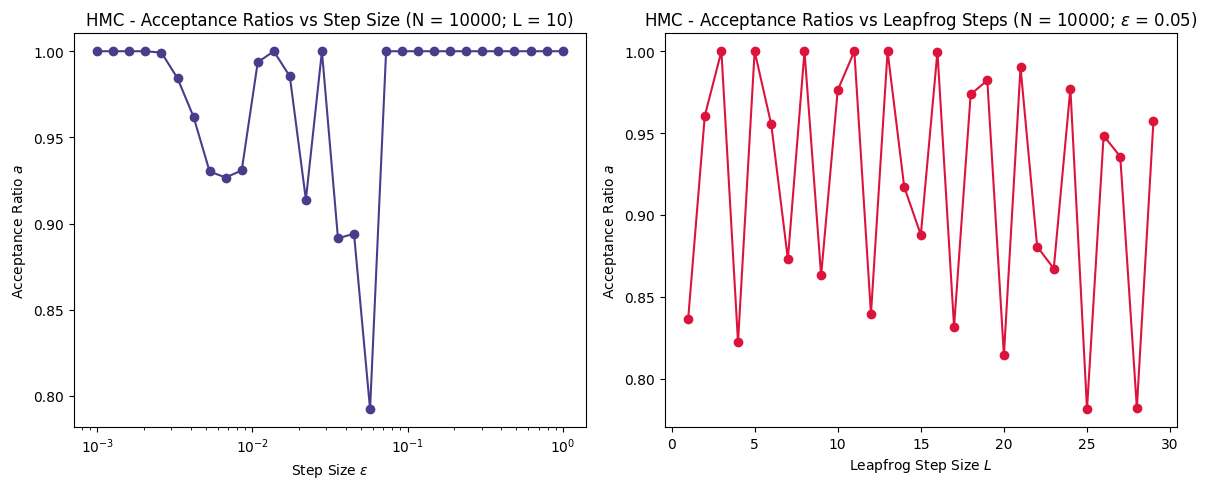

In [ ]:
# setting up subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# parameters - fix leapfrog steps
N = 10000
L = 10  # leapfrog steps
epsilon_list = np.logspace(np.log10(0.001), np.log10(1), 30)
acceptance_ratios = []

# sample over different epsilon values
for epsilon in epsilon_list:
    initial_state = np.array([0.01, 0.01])
    _, acceptance_ratio = hamiltonian_monte_carlo(N, initial_state, L, epsilon, Sigma)
    acceptance_ratios.append(acceptance_ratio)

# subplpot 1
axs[0].plot(epsilon_list, acceptance_ratios, color='DarkSlateBlue', marker='o', linestyle='-')
axs[0].set_title(f'HMC - Acceptance Ratios vs Step Size (N = {N}; L = {L})')
axs[0].set_xlabel('Step Size $\epsilon$')
axs[0].set_ylabel('Acceptance Ratio $a$')
axs[0].set_xscale('log')

# parameters - fix epsilon now
N = 10000
epsilon = 0.05
leapfrog_list = np.arange(1, 30, 1)
acceptance_ratios = []

# sample over different leapfrog steps
for L in leapfrog_list:
    initial_state = np.array([0.01, 0.01])
    _, acceptance_ratio = hamiltonian_monte_carlo(N, initial_state, L, epsilon, Sigma)
    acceptance_ratios.append(acceptance_ratio)

# subplot 2
axs[1].plot(leapfrog_list, acceptance_ratios, color='Crimson', marker='o', linestyle='-')
axs[1].set_title(f'HMC - Acceptance Ratios vs Leapfrog Steps (N = {N}; $\epsilon$ = {epsilon})')
axs[1].set_xlabel('Leapfrog Step Size $L$')
axs[1].set_ylabel('Acceptance Ratio $a$')

plt.tight_layout()
plt.show()

Study the acceptance ratio and how well the sampler
covers the entire distribution by varying the step size  , the number of leap frog
steps  . Report the optimal values.

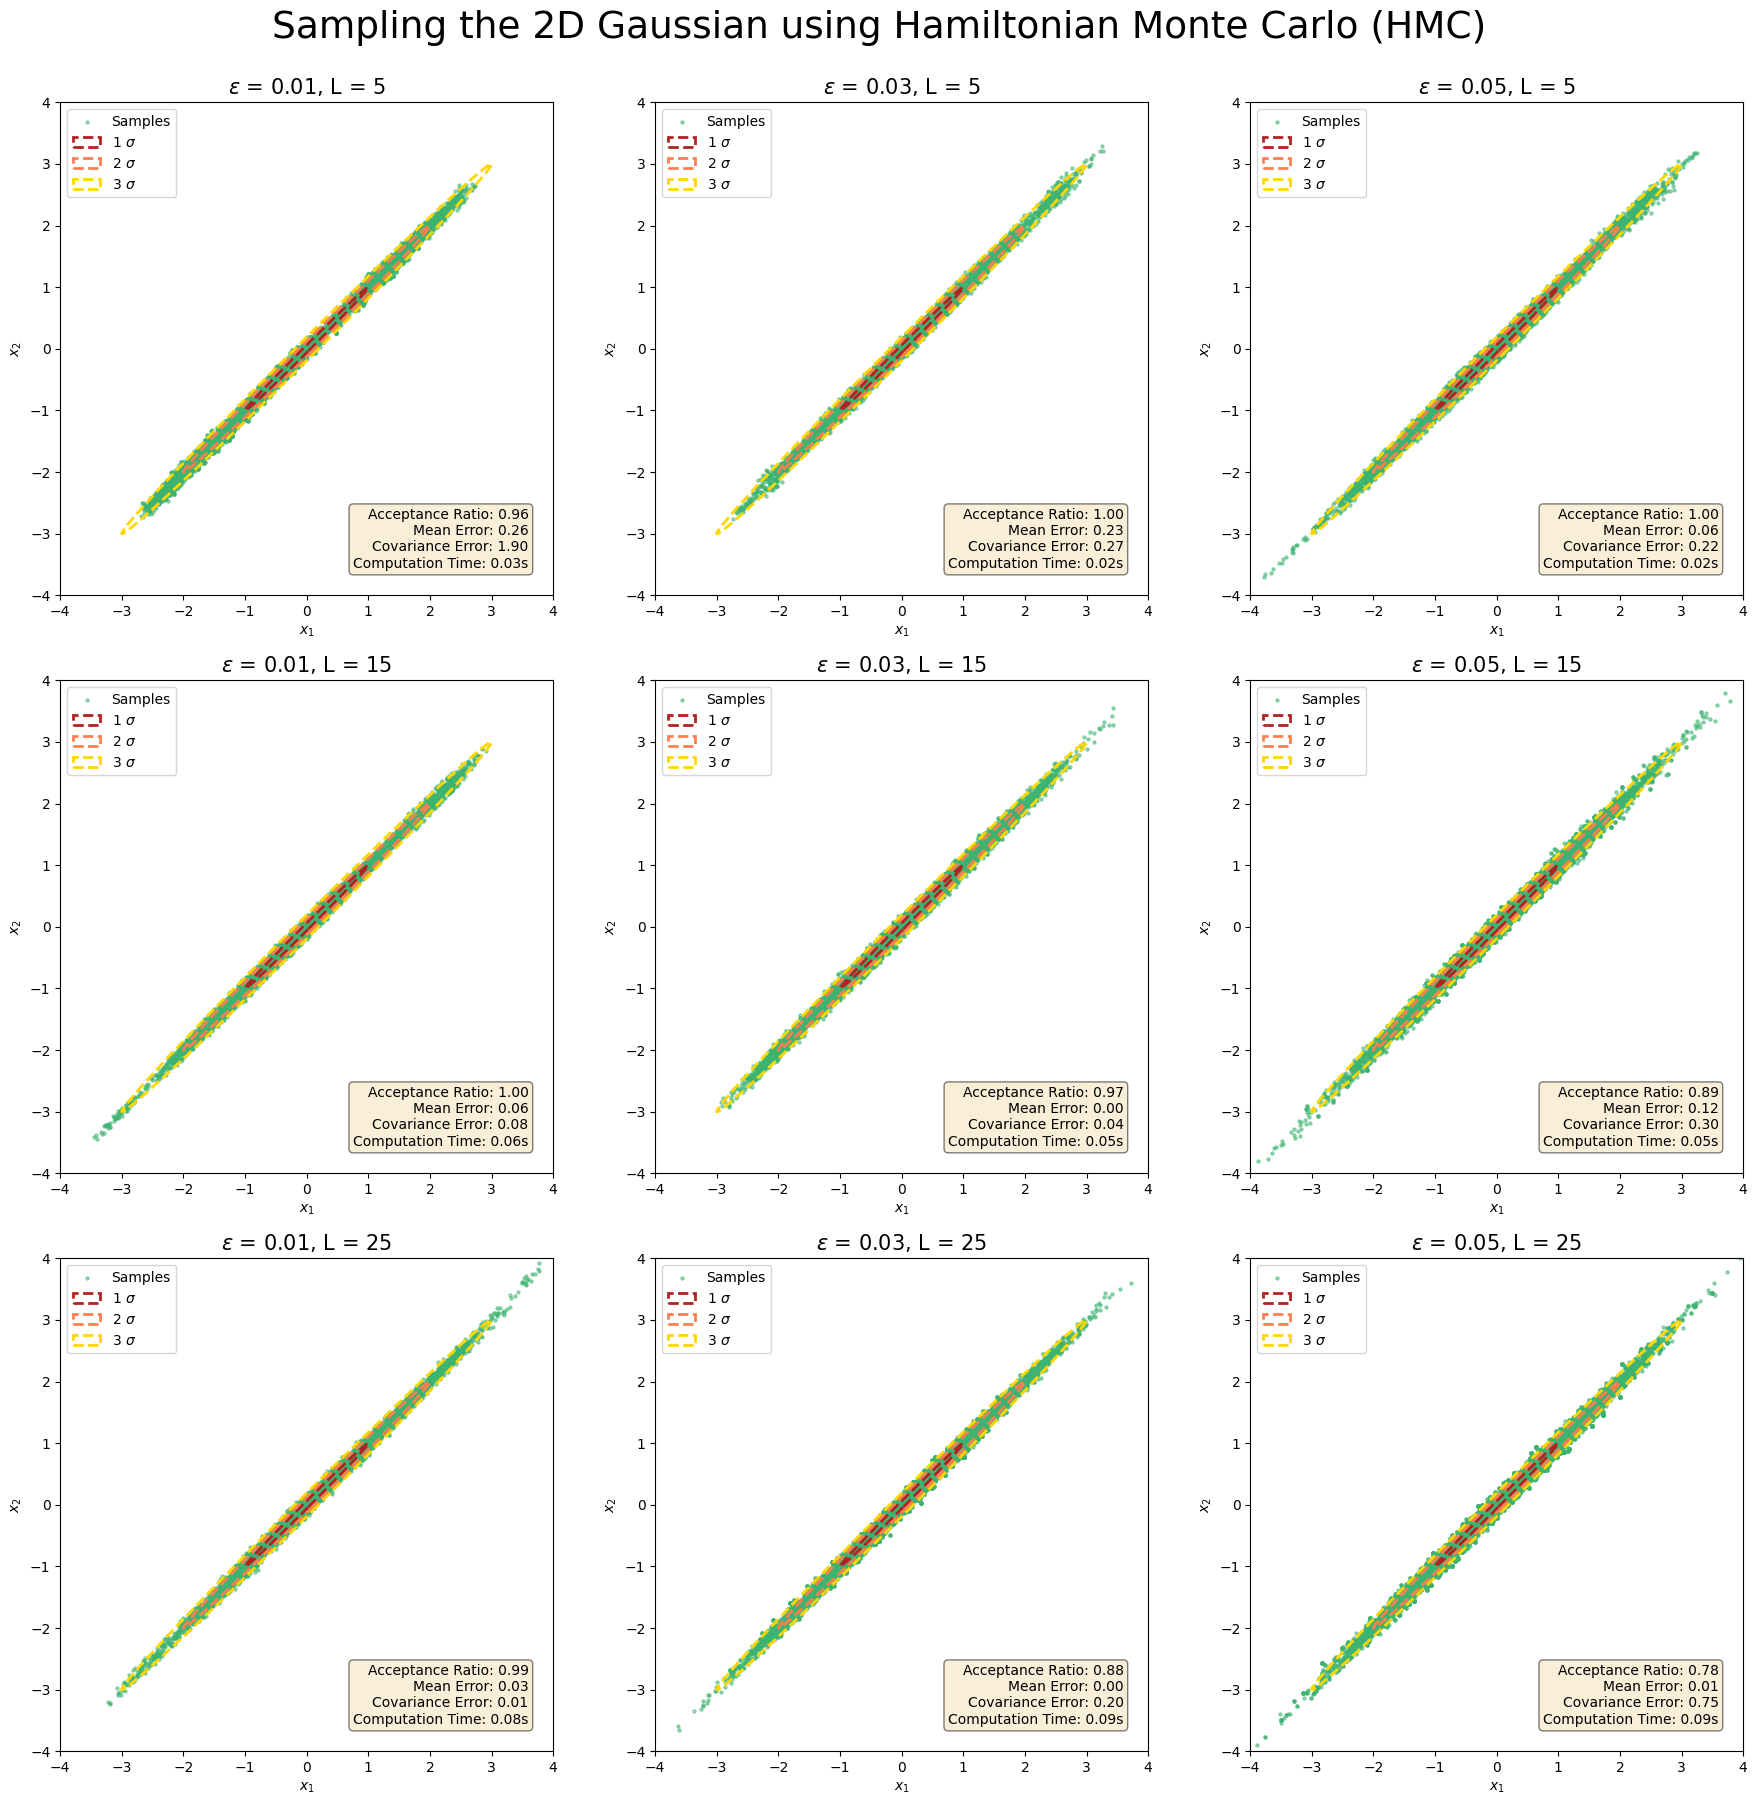

In [ ]:
# make a big 3x3 plot
N = 10000  # Number of samples
epsilon_values = [0.01, 0.03, 0.05]
leapfrog_steps = [5, 15, 25]
scale = 4 #scale of the LxL plots

# create plots
plt.figure(figsize=(18, 18))
plt.suptitle('Sampling the 2D Gaussian using Hamiltonian Monte Carlo (HMC)', fontsize=27, y=1)

for i, L in enumerate(leapfrog_steps):
    for j, epsilon in enumerate(epsilon_values):
        initial_state = np.array([0.01, 0.01])

        # run the HMC sampler
        start_time = time.time()
        samples, a_ratio = hamiltonian_monte_carlo(N, initial_state, L, epsilon, Sigma)
        comp_time = time.time() - start_time


        # Compute mean error and covariance error
        mean = np.mean(samples, axis=0)
        cov = np.cov(samples.T)
        mean_error = np.linalg.norm(mean - true_mean)
        cov_error = np.linalg.norm(cov - true_cov)

        # create a subplot
        plt.subplot(3, 3, i*3 + j + 1)

        #plot the scatter thingies
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=5, color='MediumSeaGreen', label = 'Samples')

        # plot the std ellipses
        colors = ['xd', 'FireBrick', 'Coral', 'Gold']
        for n_std in [1, 2, 3]:
            ellipse = create_ellipse(n_std, colors[n_std])
            plt.gca().add_patch(ellipse)
            ellipse.set_label(f'{n_std} $\sigma$')

        plt.title(f'$\epsilon$ = {epsilon}, L = {L}', fontsize=15)
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.xlim(-scale, scale)
        plt.ylim(-scale, scale)
        plt.gca().set_aspect('equal', 'box')
        plt.legend()

        # displaying other information in a more convenient place
        info_text = f'Acceptance Ratio: {a_ratio:.2f}\nMean Error: {mean_error:.2f}\nCovariance Error: {cov_error:.2f}\nComputation Time: {comp_time:.2f}s'
        plt.text(0.95, 0.05, info_text, transform=plt.gca().transAxes, horizontalalignment='right', verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

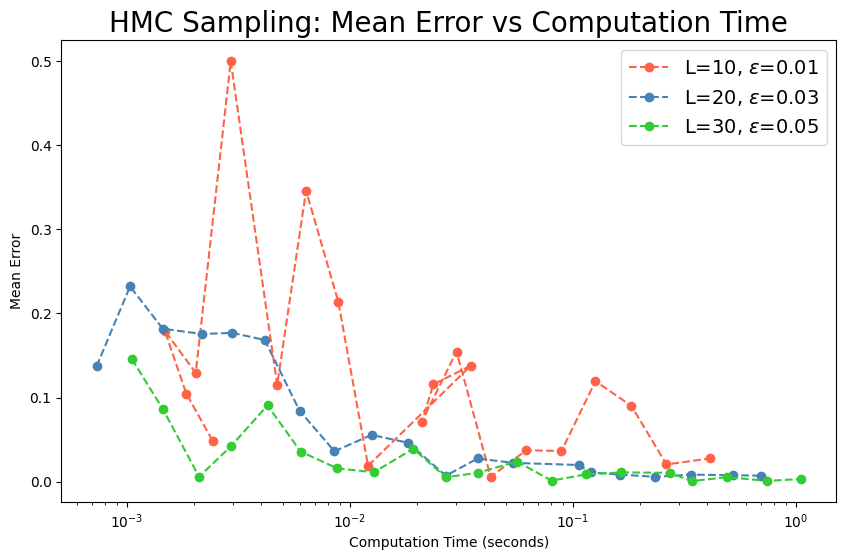

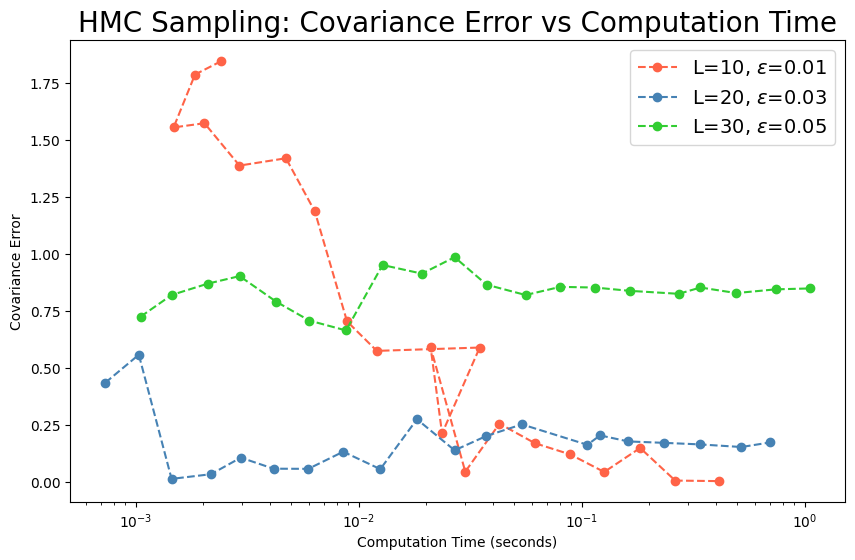

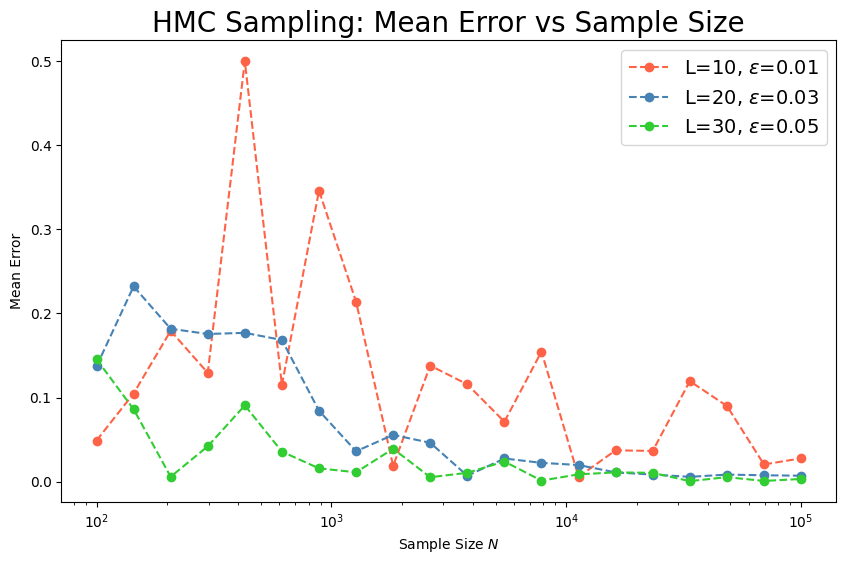

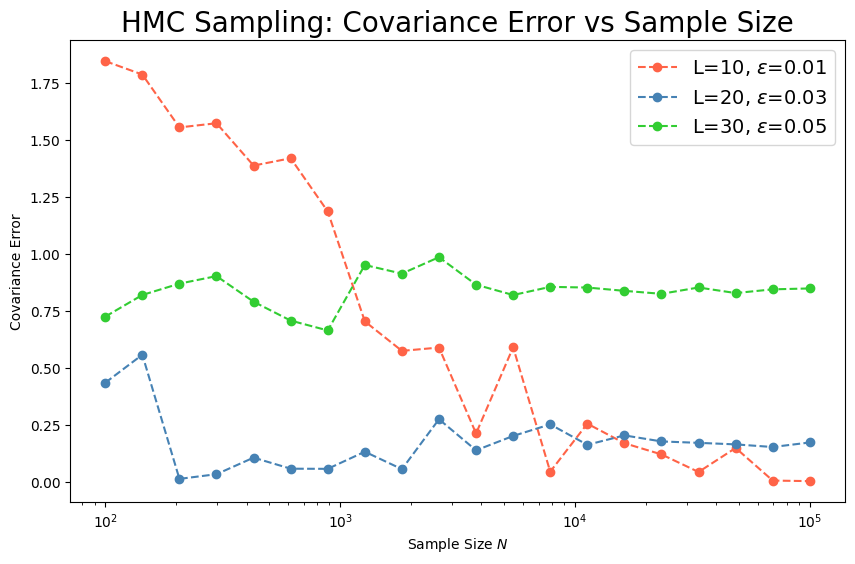

In [ ]:
def run_hmc_sampling(N_list, L_list, epsilon_list, Sigma):
    all_computation_times = []
    all_mean_errors = []
    all_cov_errors = []

    for L in L_list:
        for epsilon in epsilon_list:
            computation_times = []
            mean_errors = []
            cov_errors = []

            for N in N_list:
                N = int(N)
                run_means = []
                run_covs = []
                start_time = time.time()

                for _ in range(num_runs):
                    samples, _ = hamiltonian_monte_carlo(N, initial_state, L, epsilon, Sigma)

                    # calculate mean and covariance for this run
                    run_mean = np.mean(samples, axis=0)
                    run_cov = np.cov(samples.T)

                    run_means.append(run_mean)
                    run_covs.append(run_cov)

                comp_time = (time.time() - start_time) / num_runs  # average cpu time per run

                # Average the means and covariances across runs
                avg_run_mean = np.mean(run_means, axis=0)
                avg_run_cov = np.mean(run_covs, axis=0)

                mean_error = np.linalg.norm(avg_run_mean - true_mean)
                cov_error = np.linalg.norm(avg_run_cov - true_cov)

                computation_times.append(comp_time)
                mean_errors.append(mean_error)
                cov_errors.append(cov_error)

            all_computation_times.append(computation_times)
            all_mean_errors.append(mean_errors)
            all_cov_errors.append(cov_errors)

    return all_computation_times, all_mean_errors, all_cov_errors

# HMC parameters
N_list = np.logspace(np.log10(100),np.log10(100000),20) # values of N
L_list = [10, 20, 30]  # Leapfrog steps
epsilon_list = [0.01, 0.03, 0.05]  # Learning rates

# Run HMC sampling
hmc_computation_times, hmc_mean_errors, hmc_cov_errors = run_hmc_sampling(N_list, L_list, epsilon_list, Sigma)

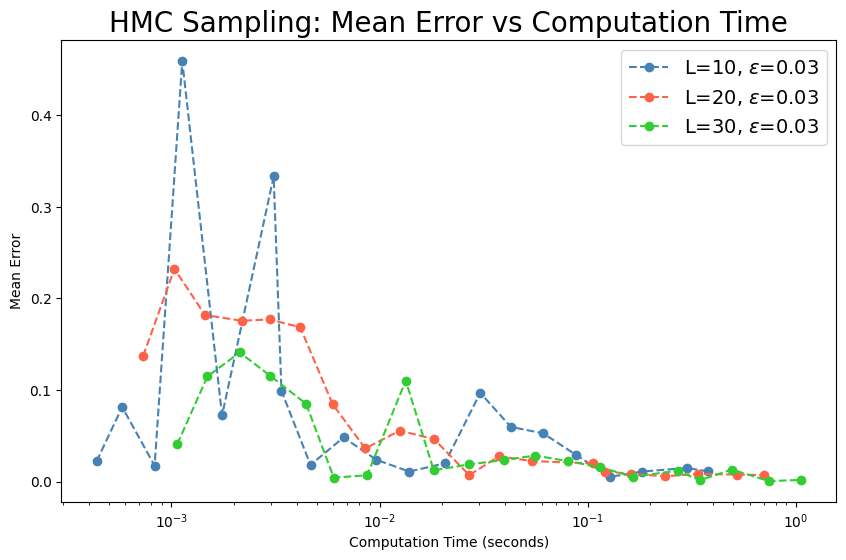

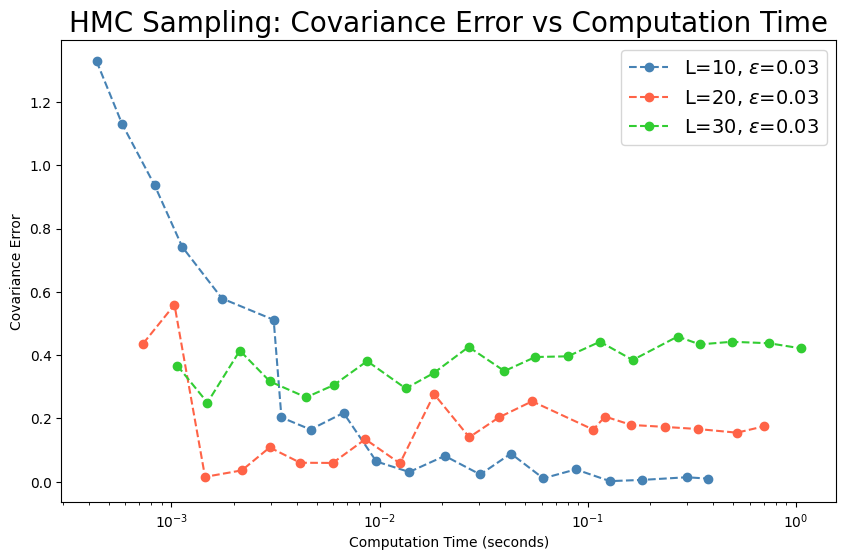

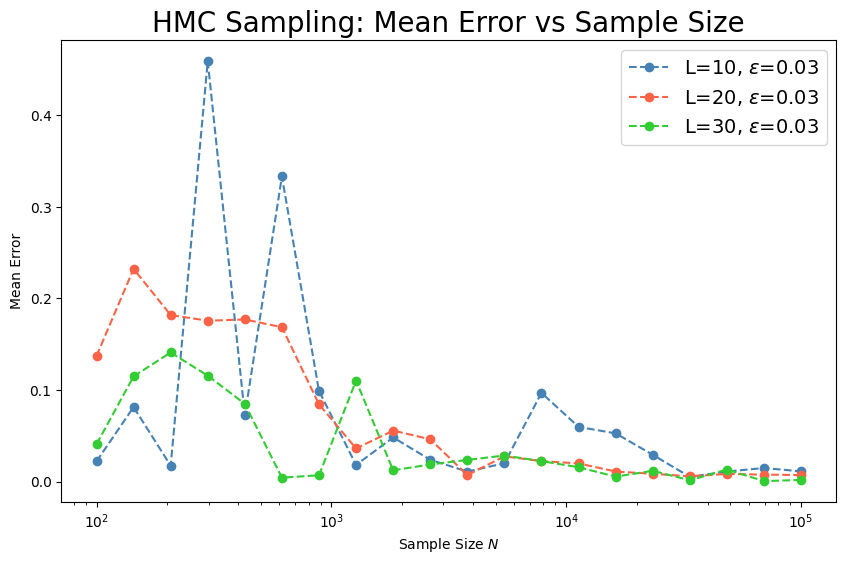

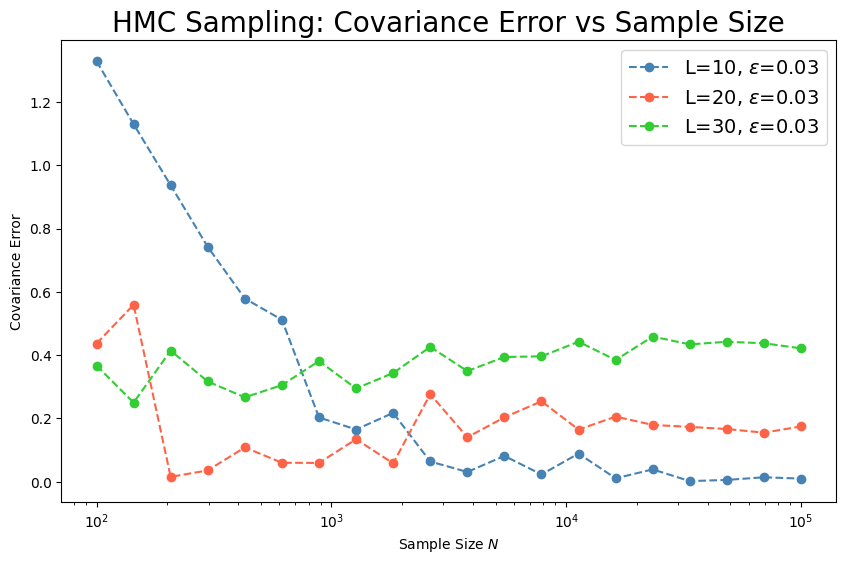

In [ ]:
# Plotting code
# Plotting code for HMC sampling
colors = ['#ff6347', '#4682b4', '#32cd32']  # Different colors for different plots
param_combinations = [(L, epsilon) for L in L_list for epsilon in epsilon_list]
plots_to_plot = [0,1,2,3,4,5,6,7,8] #Select which plots u want to see

# Plot mean error against computation time for HMC
plt.figure(figsize=(10, 6))
for i, (L, epsilon) in enumerate(param_combinations):
    if i in plots_to_plot:
      plt.plot(hmc_computation_times[i], hmc_mean_errors[i], label=f'L={L}, $\epsilon$={epsilon}', color=colors[i % len(colors)], marker='o', linestyle='dashed')

plt.title('HMC Sampling: Mean Error vs Computation Time', size=20)
plt.xlabel('Computation Time (seconds)')
plt.ylabel('Mean Error')
plt.xscale('log')
plt.legend(prop={'size': 14})
plt.show()

# Plot covariance error against computation time for HMC
plt.figure(figsize=(10, 6))
for i, (L, epsilon) in enumerate(param_combinations):
    if i in plots_to_plot:
      plt.plot(hmc_computation_times[i], hmc_cov_errors[i], label=f'L={L}, $\epsilon$={epsilon}', color=colors[i % len(colors)], marker='o', linestyle='dashed')

plt.title('HMC Sampling: Covariance Error vs Computation Time', size=20)
plt.xlabel('Computation Time (seconds)')
plt.ylabel('Covariance Error')
plt.xscale('log')
plt.legend(prop={'size': 14})
plt.show()

# Plot mean error against N for HMC
plt.figure(figsize=(10, 6))
for i, (L, epsilon) in enumerate(param_combinations):
    if i in plots_to_plot:
      plt.plot(N_list, hmc_mean_errors[i], label=f'L={L}, $\epsilon$={epsilon}', color=colors[i % len(colors)], marker='o', linestyle='dashed')

plt.title('HMC Sampling: Mean Error vs Sample Size', size=20)
plt.xlabel('Sample Size $N$')
plt.ylabel('Mean Error')
plt.xscale('log')
plt.legend(prop={'size': 14})
plt.show()

# Plot covariance error against N for HMC
plt.figure(figsize=(10, 6))
for i, (L, epsilon) in enumerate(param_combinations):
    if i in plots_to_plot:
      plt.plot(N_list, hmc_cov_errors[i], label=f'L={L}, $\epsilon$={epsilon}', color=colors[i % len(colors)], marker='o', linestyle='dashed')

plt.title('HMC Sampling: Covariance Error vs Sample Size', size=20)
plt.xlabel('Sample Size $N$')
plt.ylabel('Covariance Error')
plt.xscale('log')
plt.legend(prop={'size': 14})
plt.show()


## MCMC Exercise 2: Bayesian inference for Perceptron learning with MCMC

In this exercise you are asked to sample from the posterior of learning problem. The learning task is the perceptron/logistic regression classification problem as explained in Mackay chapter 39 and 41. The sampling methods are the Metropolis Hasting method and the Hamilton Monte Carlo method as described in MacKay chapter 29 and 30. The data are given by the files x.ext (input patterns) and t.ext (output label). Write a computer program to sample from the distribution p(w|D;$\alpha$) as given by MacKay Eqs. 41.8-10 using the Metropolis Hasting algorithm.   

Do the same using the Hamilton Monte Carlo method. For both methods, reproduce plots similar to fig. 41.5 and estimate the burn in time that is required before the sampler reaches the equilibrium distribution. Investigate the acceptance ratio for both methods and try to optimize this by varying the proposal distribution, the step size in HMC and the number of leap frog steps .

In [ ]:
t_filename = '/content/sample_data/t.ext'
x_filename = '/content/sample_data/x.ext'

# Use read_csv with custom delimiter (assuming it's a space-separated file)
t_data = pd.read_csv(t_filename, header=None, comment='%', delim_whitespace=True)
x_data = pd.read_csv(x_filename, header=None, comment='%', delim_whitespace=True)

X = x_data.to_numpy()
t = t_data.to_numpy().flatten()

# Display the loaded data
print('input patterns: \n', X)
print('output labels: \n', t)

input patterns: 
 [[1.  2.  3. ]
 [1.  3.  2. ]
 [1.  3.  6. ]
 [1.  5.5 4.5]
 [1.  5.  3. ]
 [1.  7.  4. ]
 [1.  5.  6. ]
 [1.  8.  6. ]
 [1.  9.5 5. ]
 [1.  9.  7. ]]
output labels: 
 [0 0 0 0 0 1 1 1 1 1]


MacKay Eqs. 41.8-10:
\begin{equation}
P(w | D, \alpha) = \frac{P(D | w) P(w | \alpha)}{P(D | \alpha)} = \frac{e^{-G(w)} e^{-\alpha E_W(w)}/Z_W(\alpha)}{P(D | \alpha)} = \frac{1}{Z_M} \exp(-M(w)),
\end{equation}

### Find the distribution


Find $P(w | D, \alpha)$.
Likelihood is given by $P(D|w) = e^{-G(w)}$ and prior is: $P(w|\alpha) = e^{-\alpha E_W(w)}/Z_W(\alpha)$ with $E_W(w)$ being the energy function and $Z_W(\alpha)$ the normalization constant

In [ ]:
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the likelihood function
def likelihood(w, X, t):
    y = sigmoid(X @ w)
    G = -np.sum(t * np.log(y) + (1 - t) * np.log(1 - y))
    return np.exp(-G)

# Define the prior function
def prior(w, alpha):
    EW = 0.5 * np.dot(w, w)  # Assuming a zero-mean Gaussian prior
    ZW = (2 * np.pi / alpha) ** (len(w) / 2)  # Normalization constant
    return np.exp(-alpha * EW) / ZW

# Define the unnormalized posterior function
def unnormalized_posterior(w, X, t, alpha):
    return likelihood(w, X, t) * prior(w, alpha)


# Define a function to calculate the posterior distribution over a grid of weight values
def calculate_posterior_distribution(w_values, X, t, alpha):
    posterior_values = np.zeros_like(w_values)
    for i in range(w_values.shape[0]):
        for j in range(w_values.shape[1]):
            w = np.array([w_values[i, j]])
            posterior_values[i, j] = unnormalized_posterior(w, X, t, alpha)
    return posterior_values

# Define the energy function
def energy(w, X, t, alpha):
    return -np.log(unnormalized_posterior(w, X, t, alpha))



### Sample using Metropolis Hasting algorithm

In [ ]:
def metropolis_hastings(p, dim, iter=50000):
    # Initialize the state
    alpha  = 0.01
    sigma  = 0.3
    current_state = np.array([-5,0,0])

    # Initialize the list of samples and the weight updates
    samples = [current_state]
    w1_updates = [current_state[0]]
    w2_updates = [current_state[1]]
    w3_updates = [current_state[2]]

    # Initialize the acceptance count and acceptance ratio list
    acceptance_count = 0
    acceptance_ratios = []

    for i in range(iter-1):
        # Propose a new state
        proposal = current_state + sigma * np.random.randn(dim)

        # Compute the acceptance ratio
        a = min(1, p(proposal,alpha) / p(current_state,alpha))

        # Accept or reject the proposed state
        if np.random.rand() < a:
            current_state = proposal
            acceptance_count += 1

        # Add the current state to the list of samples
        samples.append(current_state)

        # Keep track of the weight updates
        w1_updates.append(current_state[0])
        w2_updates.append(current_state[1])
        w3_updates.append(current_state[2])

        # Calculate and store the acceptance ratio
        acceptance_ratios.append(acceptance_count / (i+1))

    return np.array(samples), acceptance_ratios, w1_updates, w2_updates, w3_updates


def p(x,alpha):
    return unnormalized_posterior(x, X, t, alpha)


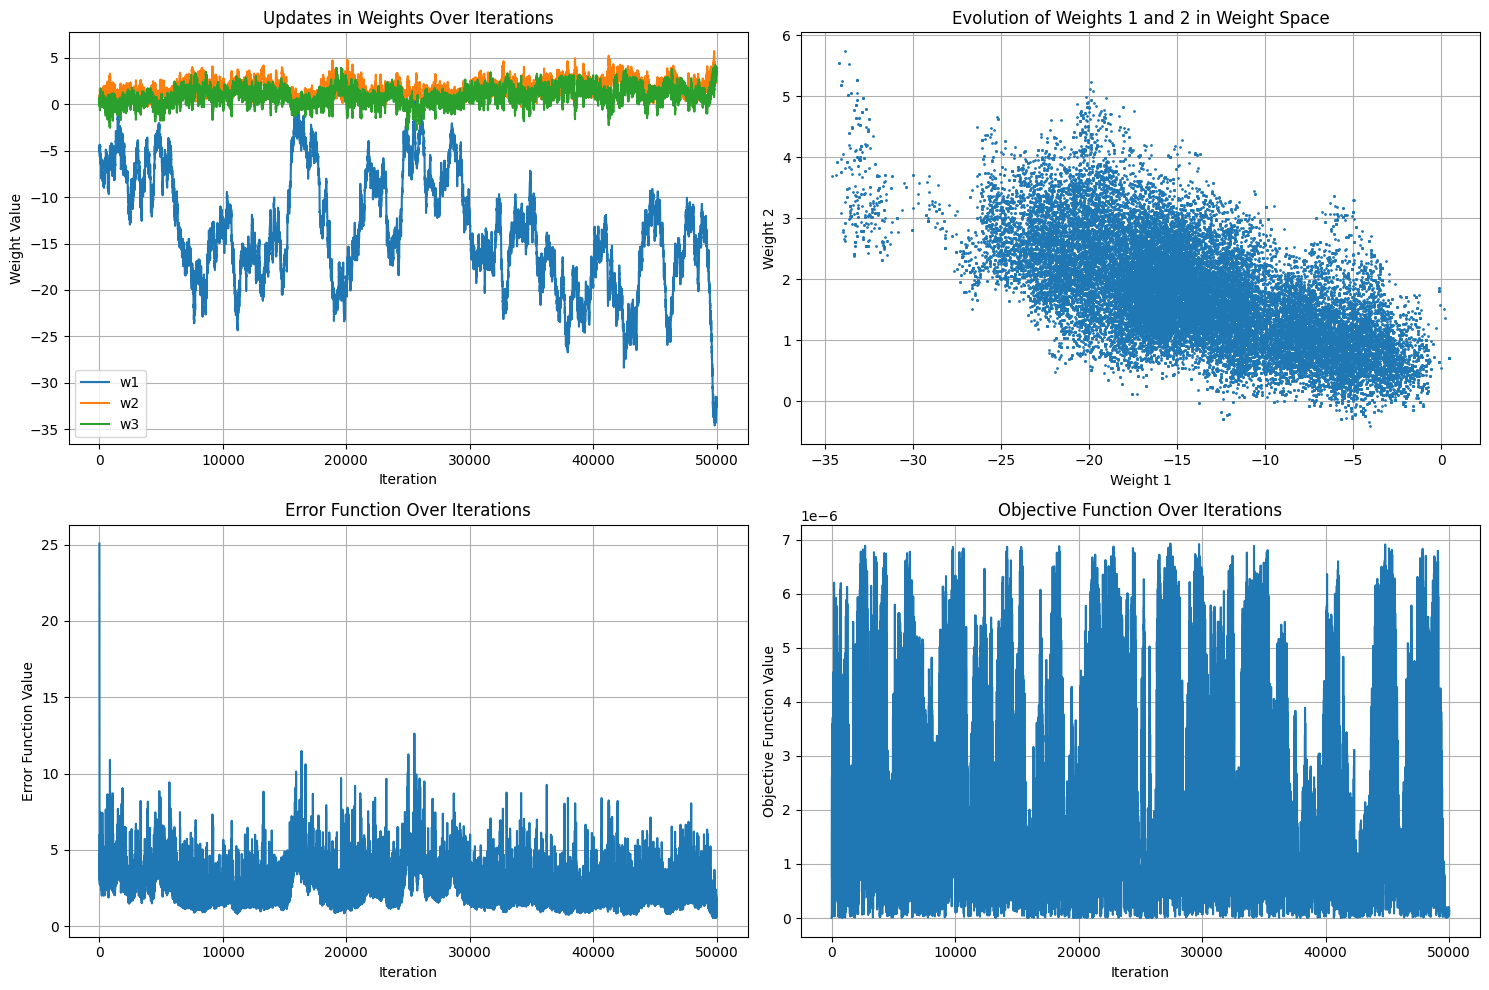

In [ ]:
# replicate figure 41.5
np.random.seed(42)

# Assume you have run your Metropolis-Hastings function and stored the output in `samples`, `acceptance_rate`, `w1_updates`, `w2_updates`, and `w3_updates`
samples, acceptance_ratios, w1_updates, w2_updates, w3_updates = metropolis_hastings(p, dim=X.shape[1], iter=50000)

# Define the error function G(w)
def error_function(w, X, t):
    y = sigmoid(X @ w)
    return -np.sum(t * np.log(y) + (1 - t) * np.log(1 - y))

alpha  = 0.01
sigma  = 0.3

# Calculate the error function and objective function for each sample
error_values = [error_function(w, X, t) for w in samples]
objective_values = [unnormalized_posterior(w, X, t, alpha) for w in samples]

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the weight updates
axs[0, 0].plot(w1_updates, label='w1')
axs[0, 0].plot(w2_updates, label='w2')
axs[0, 0].plot(w3_updates, label='w3')
axs[0, 0].set_title('Updates in Weights Over Iterations')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Weight Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot the evolution of weights 1 and 2 in weight space
axs[0, 1].plot(w1_updates, w2_updates, '.', markersize=2, linewidth=0.5)
axs[0, 1].set_title('Evolution of Weights 1 and 2 in Weight Space')
axs[0, 1].set_xlabel('Weight 1')
axs[0, 1].set_ylabel('Weight 2')
axs[0, 1].grid(True)



# Plot the error function values
axs[1, 0].plot(error_values, '-')
axs[1, 0].set_title('Error Function Over Iterations')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Error Function Value')
axs[1, 0].grid(True)

# Plot the objective function values
axs[1, 1].plot(objective_values, '-')
axs[1, 1].set_title('Objective Function Over Iterations')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Objective Function Value')
axs[1, 1].grid(True)

# Display the figure
plt.tight_layout()
plt.show()

In [ ]:
# estimating the burn time for MH
# judging by the error function over iterations graph,
# it looks like the sampling error stabilises more after around 30000 iterations,
# otherwise, I will assume that the errror function may converge after 50000 iterations, or else, this oscillatory patter may continue

# average error from entire sampling
average_error = np.mean([error_function(w, X, t) for w in samples])
print("average error without slicing after burner time: ", average_error)

# Define a burn-in period based on the observed stabilization
burn_in_period = 30000

# Discard the burn-in samples
burned_in_samples = samples[burn_in_period:]

# Compute the average error after burn-in
average_error_after_burn_in = np.mean([error_function(w, X, t) for w in burned_in_samples])
print('average error after burner time: ',average_error_after_burn_in)


average error without slicing after burner time:  2.636955253834199
average errpr after burner time:  2.201602352334319


I would propose for a more thorough analysis, a more comprehensive test is necessary. But I understood the task at hand to be 'estimate' the burn time, thus judged by eye looking at the error function.

### Sample using Hamilton Monte Carlo method

In [ ]:
# Define the gradient of the energy function
def grad_E(w, X, t, alpha):
    eps = np.sqrt(np.finfo(float).eps)
    return approx_fprime(w, energy, eps, X, t, alpha)

# Define the Hamiltonian Monte Carlo function
def hamiltonian_monte_carlo(N, w0, L, epsilon, X, t, alpha):
    samples = [w0]
    acceptance_count = 0

    for _ in range(N):
        w = samples[-1].copy()
        p = np.random.normal(0, 1, len(w0))
        current_p = np.copy(p)

        current_U = energy(samples[-1], X, t, alpha)
        current_K = np.sum(current_p**2) / 2
        current_H = current_U + current_K

        for _ in range(L):
            p -= epsilon * grad_E(w, X, t, alpha) / 2
            w += epsilon * p
            p -= epsilon * grad_E(w, X, t, alpha) / 2

        proposed_U = energy(w, X, t, alpha)
        proposed_K = np.sum(p**2) / 2
        proposed_H = proposed_U + proposed_K

        dH = proposed_H - current_H
        a = min(1, np.exp(-dH)) #prevent overflow with min

        if dH < 0:
            samples.append(w)
            acceptance_count += 1
        elif np.random.rand() < a:
            samples.append(w)
            acceptance_count += 1
        else:
            samples.append(samples[-1])

    acceptance_rate = acceptance_count / N
    return np.array(samples), acceptance_rate

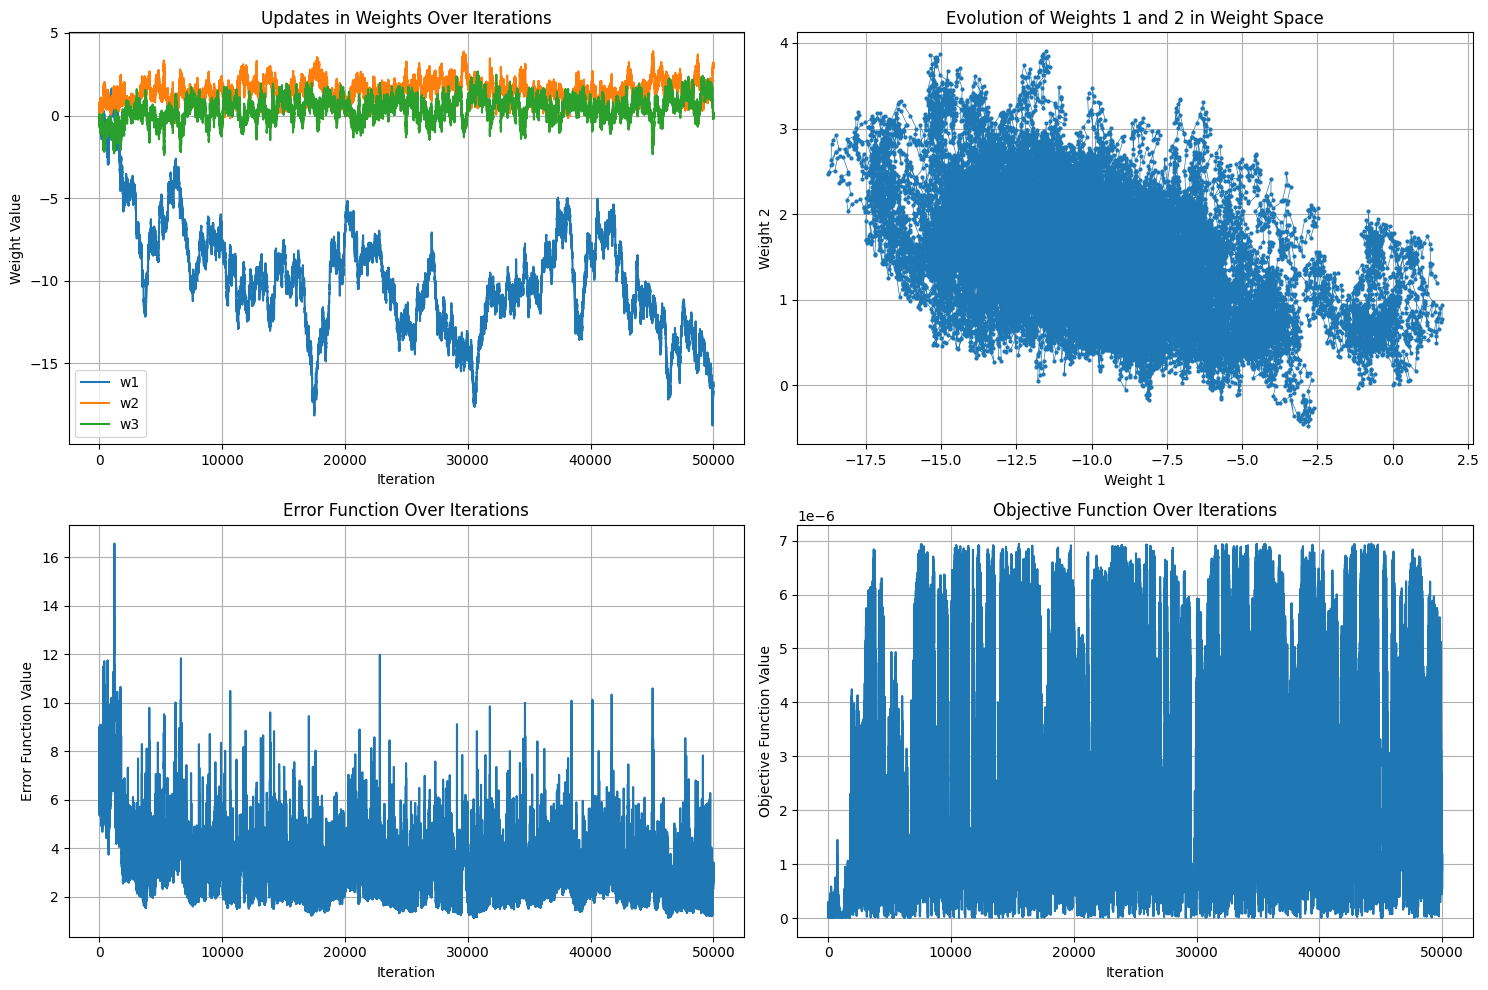

'time taken for this was 4m 5.2s'

In [ ]:
# replicate figure 41.5

N = 50000
w0 = np.zeros(X.shape[1])
L = 10
epsilon = 0.01
np.random.seed(42)


# Assume you have run your Hamiltonian Monte Carlo function and stored the output in `samples` and `acceptance_rate`
samples, acceptance_rate = hamiltonian_monte_carlo(N, w0, L, epsilon, X, t, alpha)

# Separate the components of the vectors
w1_updates = samples[:, 0]
w2_updates = samples[:, 1]
w3_updates = samples[:, 2]

# Calculate the error function and objective function for each sample
error_values = [error_function(w, X, t) for w in samples]
objective_values = [unnormalized_posterior(w, X, t, alpha) for w in samples]

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the weight updates
axs[0, 0].plot(w1_updates, label='w1')
axs[0, 0].plot(w2_updates, label='w2')
axs[0, 0].plot(w3_updates, label='w3')
axs[0, 0].set_title('Updates in Weights Over Iterations')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Weight Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot the evolution of weights 1 and 2 in weight space
axs[0, 1].plot(w1_updates, w2_updates, 'o-', markersize=2, linewidth=0.5)
axs[0, 1].set_title('Evolution of Weights 1 and 2 in Weight Space')
axs[0, 1].set_xlabel('Weight 1')
axs[0, 1].set_ylabel('Weight 2')
axs[0, 1].grid(True)

# Plot the error function values
axs[1, 0].plot(error_values)
axs[1, 0].set_title('Error Function Over Iterations')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Error Function Value')
axs[1, 0].grid(True)

# Plot the objective function values
axs[1, 1].plot(objective_values)
axs[1, 1].set_title('Objective Function Over Iterations')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Objective Function Value')
axs[1, 1].grid(True)

# Display the figure
plt.tight_layout()
plt.show()

"""time taken for this was 4m 5.2s"""

In [ ]:
# estimating the burn in time of HMC
# again, from the Error function over Iterations graph, I can observe that the error function
# only converges / stabilises after around 45000 and I am assuming that by increasing the number of iterations,
# it would converge even further after that point.

# average error from entire sampling
average_error = np.mean([error_function(w, X, t) for w in samples])
print("average error without slicing after burner time: ", average_error)

# Define a burn-in period based on the observed stabilization
burn_in_period = 45000

# Discard the burn-in samples
burned_in_samples = samples[burn_in_period:]

# Compute the average error after burn-in
average_error_after_burn_in = np.mean([error_function(w, X, t) for w in burned_in_samples])
print('average error after burner time: ',average_error_after_burn_in)


average error without slicing after burner time:  2.9561677017685906
average errpr after burner time:  2.4565153759624163


### Investigate the acceptance ratio for both methods


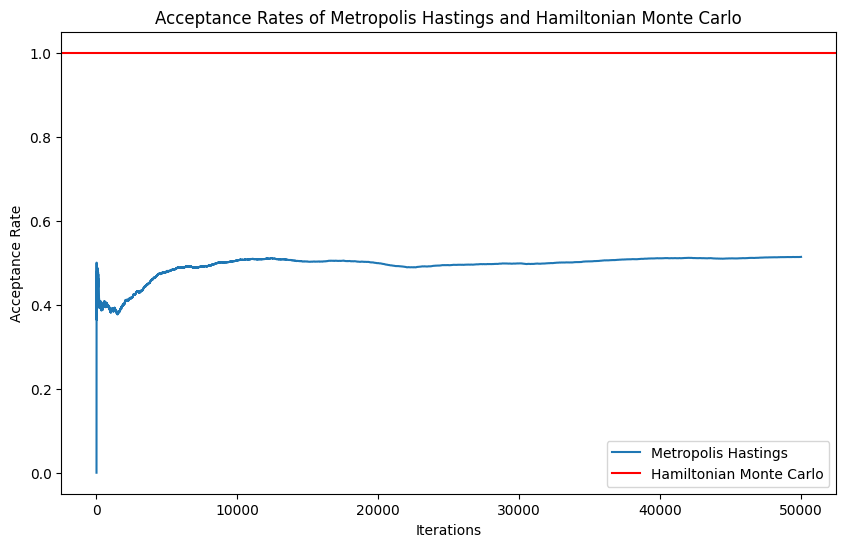

In [ ]:
# Number of iterations
iterations = 50000

# Run the Metropolis Hastings method
samples_mh, acceptance_rate_mh, _, _, _ = metropolis_hastings(p, dim=3, iter=iterations)

# Run the Hamiltonian Monte Carlo method
samples_hmc, acceptance_ratio_hmc = hamiltonian_monte_carlo(iterations, w0=np.array([-5.0,0.0,0.0]), L=10, epsilon=0.01, X=X, t=t, alpha=0.01)

# Create an array with the number of iterations
iter_array = np.arange(1, iterations)

# Ensure the samples_hmc array has the same shape as iter_array
if samples_hmc.shape[0] > iter_array.shape[0]:
    samples_hmc = samples_hmc[:-1]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the Metropolis Hastings acceptance rate
plt.plot(iter_array, acceptance_rate_mh, label='Metropolis Hastings')

# Plot the Hamiltonian Monte Carlo acceptance rate as a horizontal line
plt.axhline(y=acceptance_ratio_hmc, color='r', linestyle='-', label='Hamiltonian Monte Carlo')

# Add a legend
plt.legend()

# Add labels and a title
plt.xlabel('Iterations')
plt.ylabel('Acceptance Rate')
plt.title('Acceptance Rates of Metropolis Hastings and Hamiltonian Monte Carlo')

# Show the plot
plt.show()

Thus, we observe the acceptance rate of the HMC to be close to 100% -- which is a good indication that the chosen parameters are a good fit for our model. On the other hand, we see the acceptance rate of the MH to stabilise after about 10000 iterations at a 50% aceeptance ratio.

### optimize this by varying the proposal distribution, the step size $\epsilon$ in HMC and the number of leap frog steps $\tau$

<ipython-input-3-37918ca0c1aa>:8: RuntimeWarning: divide by zero encountered in log
  G = -np.sum(t * np.log(y) + (1 - t) * np.log(1 - y))
<ipython-input-3-37918ca0c1aa>:8: RuntimeWarning: invalid value encountered in multiply
  G = -np.sum(t * np.log(y) + (1 - t) * np.log(1 - y))


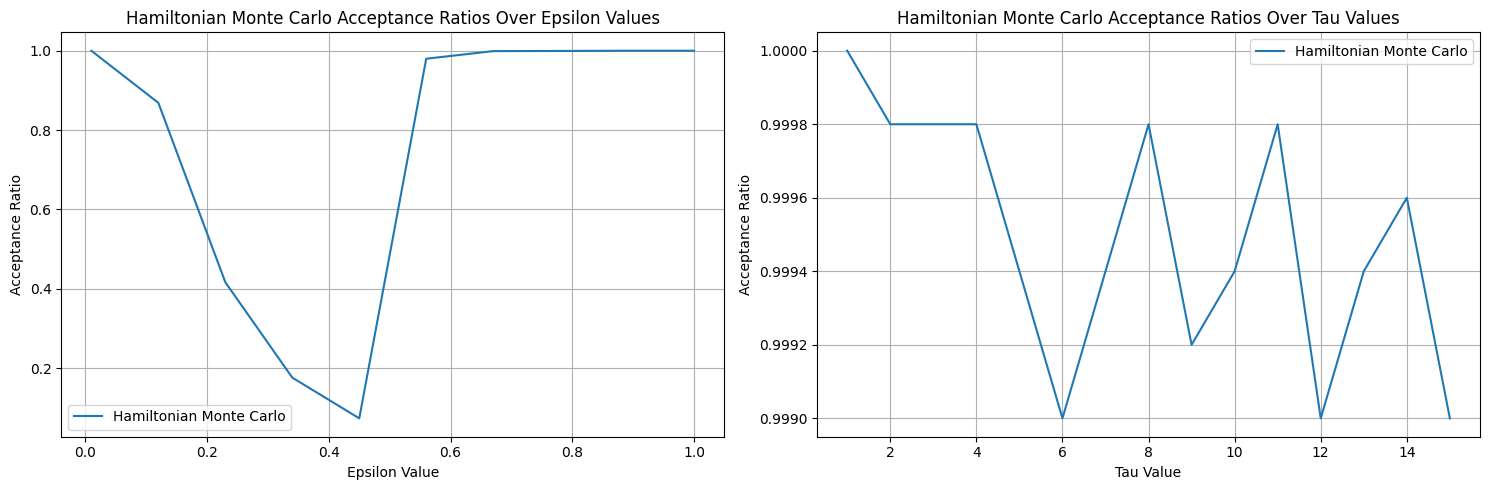

In [ ]:
N = 5000
w0 = np.zeros(X.shape[1])
alpha = 0.5
# Define a range of values for epsilon and tau
epsilon_values = np.linspace(0.01, 1, 10)
tau_values = np.arange(1, 16)

# Initialize lists to store the acceptance ratios
hmc_epsilon_acceptance_ratios = []
hmc_tau_acceptance_ratios = []

# Perform a parameter sweep for the Hamiltonian Monte Carlo method
for epsilon in epsilon_values:
    _, acceptance_rate = hamiltonian_monte_carlo(N, w0, tau_values[0], epsilon, X, t, alpha)
    hmc_epsilon_acceptance_ratios.append(acceptance_rate)

# Perform a parameter sweep for the Hamiltonian Monte Carlo method
for tau in tau_values:
    _, acceptance_rate = hamiltonian_monte_carlo(N, w0, tau, epsilon_values[0], X, t, alpha)
    hmc_tau_acceptance_ratios.append(acceptance_rate)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the acceptance ratios for epsilon
axs[0].plot(epsilon_values, hmc_epsilon_acceptance_ratios, label='Hamiltonian Monte Carlo')
axs[0].set_title('Hamiltonian Monte Carlo Acceptance Ratios Over Epsilon Values')
axs[0].set_xlabel('Epsilon Value')
axs[0].set_ylabel('Acceptance Ratio')
axs[0].legend()
axs[0].grid(True)

# Plot the acceptance ratios for tau
axs[1].plot(tau_values, hmc_tau_acceptance_ratios, label='Hamiltonian Monte Carlo')
axs[1].set_title('Hamiltonian Monte Carlo Acceptance Ratios Over Tau Values')
axs[1].set_xlabel('Tau Value')
axs[1].set_ylabel('Acceptance Ratio')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


From this we can observe that perhaps a value of $\epsilon$ that is closer to 1 is more suited for optimising the Hamiltonian Monte Carlo, and on the contrary, the leap frog step $\tau$ chould be lower (values from 2 - 4 gave higher acceptance rates).